# Replicate the Basener-Sanford numerical experiments

We will establish that my Python code, when instructed to do some dubious and some erroneous operations that Basener's code does, generates the results that Basener and Sanford present in Section 5. Their data, which the notebook [RunBasenerScript](./RunBasenerScript.ipynb) generates by running an excerpt of Basener's code, [BS.js](./BS.js), is included in the binder:

In [1]:
%ls bs5_*.json.gz

bs5_2aux.json.gz  bs5_2.json.gz  bs5_3.json.gz  bs5_4.json.gz


It bears emphasis that my code, [bs.py](./bs.py), works quite differently than Basener's does. None of it is a simple translation from one language to another. To replicate the experiments precisely, we must override the default operation of my system in nine ways. None of the overrides is along the lines of "copy this bug." They all will be described in abstraction. Thus we will arrive at a genuine *understanding* of how Basener and Sanford got the results that they did.

**For users connected to a Jupyter Notebook server.** To see animations in place of several of the following figures, change the default number of frames in an animation, `NFRAMES`, from `None` to `100` (recommended) in the following cell. Then select `Restart & Run All` in the `Kernel` tab above.

In [45]:
%matplotlib notebook
%run bs.py

NFRAMES=None # Change `None` to 100 to get animations

plt.rcParams['animation.html'] = 'jshtml' # 'html5' requires FFmpeg installation on server
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})
sns.set_palette(sns.color_palette("Set2", 4))

## Distribution of probability over discrete mutation effects

The continuous domain of mutation effects on fitness is restricted to a finite interval centered on zero. The interval is partitioned into an odd number of subintervals of equal length, one of which is centered on zero. For each subinterval, the probability distributed over the subinterval is assigned to the point at the center of the subinterval.

1\. **\[`approximate=True`\] Approximate probabilities.** Although it is easy to calculate the probability mass distributed over a finite interval centered on mutation effect $x$, Basener resorts to crude approximation, multiplying the probability density at $x$ by the length of the interval.

2\. ** \[`gimmick=True`\] Set the probability of no mutation effect to the probability of minimally deleterious effect.** For the reflected Gamma distribution of BS Section 5.4, the probability density at zero is undefined. However, the probability mass of the interval centered on zero, i.e., the probability that mutation is neutral in effect, is perfectly well defined. The probability of neutral mutation is the difference of unity (the number 1) and the probability of non-neutral mutation. Basener instead sets the probability that mutation has no effect on fitness to the probability that mutation has a minimally deleterious effect., which is much less than the correct quantity. BS do not report the gimmick in their article, though their results are critically dependent upon it. The gimmick would be fairly easy to detect if the distribution were plotted in [Figure 1](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs00285-017-1190-x/MediaObjects/285_2017_1190_Fig1_HTML.gif) as they claim. We will establish that BS have made the gimmick impossible to see by plotting a different distribution.

3\. **\[`normed=False`\] Reweight probabilities under a false assumption.** BS erroneously claim to have set the probability of beneficial mutation to .001 in Section 5.4. The correct method is to scale the probabilities for positive mutation effects by $.001/p_b,$ and to scale the probabilities of non-positive mutation effects by $.999/p_n,$ where $p_b$ and $p_n$ are, respectively, the initial probabilities of beneficial and non-beneficial mutation. Note that this yields a normalized distribution. In his code, Basener essentially assumes that $p_b$ and $p_n$ are both equal to .5. This clearly cannot be the case for a symmetric distribution with zero effect at the center, because the non-beneficial mutations include mutations with zero effect on fitness, and the beneficial mutations do not. What holds initially for the symmetrized Gamma distribution of BS Section 5.4 is that the probabilities of beneficial and deleterious (not neutral) mutation are identically equal to **???***

4\. **\[`normed=False`\] Do not normalize the distribution.** Basener does not normalize the probability distributions. The sum of the probabilities in his gimmicky Gamma distribution is only .82. This is quite a severe error, inasmuch as it effectively reduces the fitnesses (Malthusian growth rates) to 82 percent of their stated values.

We will compare processes with default distributions to processes with BS distributions.

In [46]:
# Sections 5.1 and 5.2
zero_effects = EffectsDistribution()

# Section 5.3
gauss_effects = GaussianEffects()
bs_gauss_effects = GaussianEffects(approximate=True, normed=False)

# Section 5.4
gamma_effects = GammaEffects()
bs_gamma_effects = GammaEffects(approximate=True, normed=False, gimmick=True)

## Distribution of the initial population over fitnesses

5\. **\[``approximate=True``\] Approximate proportions.** The Gaussian distribution of the initial population over fitnesses is discretized precisely as the distributions of probability over mutation effects are, with approximation of the probability masses for intervals.
   
6\. **\[``crop=11.2``\] Crop at 11.2 standard deviations from the mean.** 

In [47]:
bs_zero_init = GaussianRates(zero_effects.n_rates, crop=11.2, approximate=True)
bs_gauss_init = GaussianRates(gauss_effects.n_rates, crop=11.2, approximate=True)
bs_gamma_init = GaussianRates(gamma_effects.n_rates, crop=11.2, approximate=True)

## Annual update of the population

7\. **\[class BS_Population\]** Linear rates

8\. **\[threshold_norm=np.max\]** The threshold is not, as BS claim, defined in terms of the sum.

9\. **\[class BS_Population\]** Discard out-of-bounds results of convolution.

We pair BS mutation effects distributions with `BS_Population`, and default mutation effects distributions with `Population`. 

In [48]:
zero_pop = Population(bs_zero_init, zero_effects, label='Default zero')
bs_zero_pop = BS_Population(bs_zero_init, zero_effects, threshold_norm=np.max, label='BS zero')

gauss_pop = Population(bs_gauss_init, gauss_effects, label='Default gauss')
bs_gauss_pop = BS_Population(bs_gauss_init, bs_gauss_effects, threshold_norm=np.max, label='BS gauss')

gamma_pop = Population(bs_gamma_init, gamma_effects, label='Default gamma')
bs_gamma_pop = BS_Population(bs_gamma_init, bs_gamma_effects, threshold_norm=np.max, label='BS gamma')

## Gaussian distribution over mutation effects (Sect 5.3)

Here the distribution of probability over the effects of mutation on fitness is zero-mean Gaussian. The standard deviation in Basener's script does not match that of the BS study, 0.002, so I have changed it in `BS.js`.

We start by instantiating an evolutionary process in Python. Most of the default values of parameters are appropriate for replicating the BS experiment. We supply values for parameters only as necessary. The `crop=11.2` setting in the initial distribution of the population causes the frequencies of growth rates differing from the mean by more than 11.2 standard deviations to be zero.

In [49]:
n_rates = gauss_effects.n_rates
n_years = 300
gauss = Evolution(gauss_pop, n_years=n_years)
bs_gauss = Evolution(bs_gauss_pop, n_years=n_years)

Let's have a look at the discrete distribution over mutation effects. The mean and standard deviation in the subtitle of the following figure are calculated using the discrete distribution. The calculated value of the standard deviation should be close to that of the continuous distribution, 0.002.

<IPython.core.display.Javascript object>


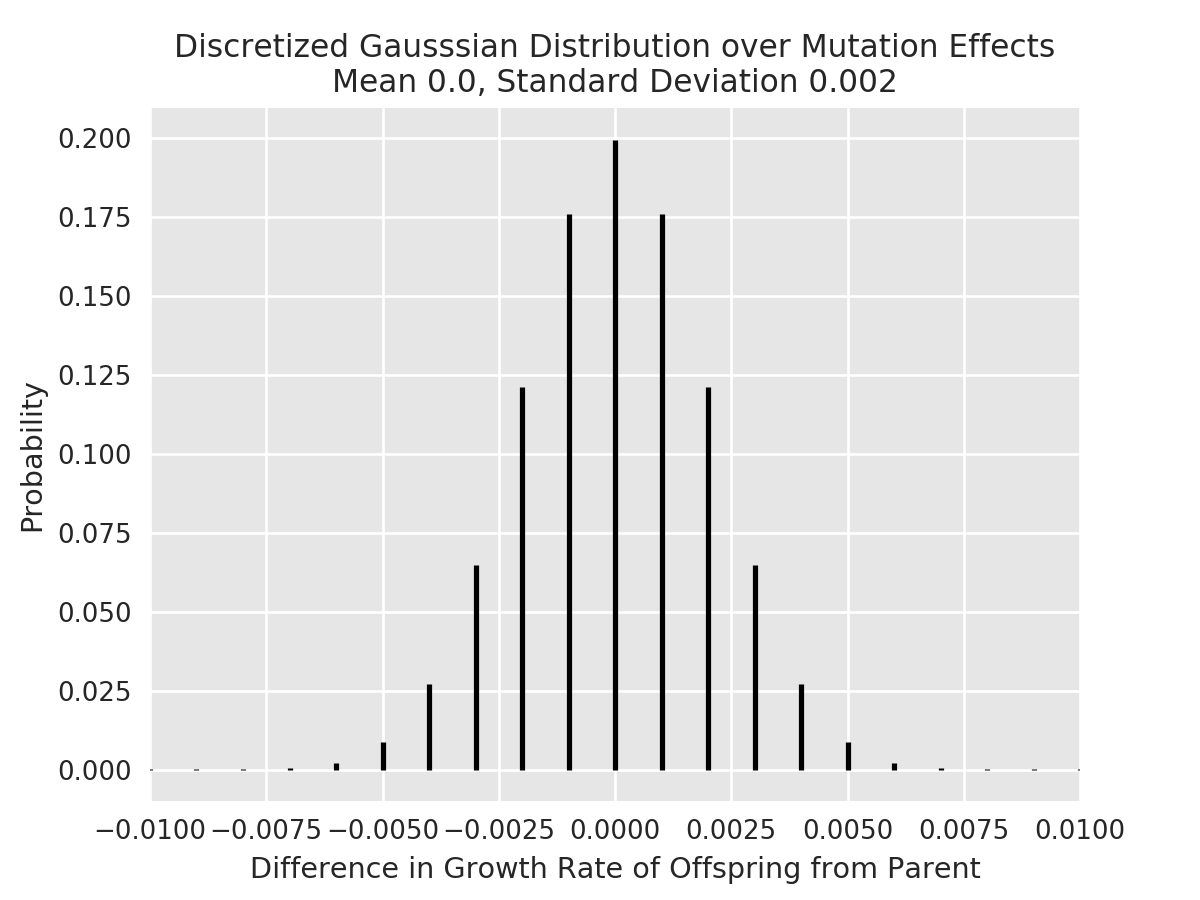

In [50]:
fig = bs_gauss_effects.plot('Discretized Gausssian Distribution over Mutation Effects')
fig.gca().set_xlim(-0.01, 0.01);

Now we do the corresponding run of Basener's JavaScript. The standard deviation in his code was not set to 0.002 as in the BS article, so I changed it. First we generate a command line `c`, and then submit it to the command line interpreter (shell) of the host computer.

In [51]:
c = bs_command(percentage_of_mutations_that_are_beneficial=None,
               mutation_distribution_type='Gaussian',
               population_size='Finite',
               number_of_years=n_years+1,
               number_of_discrete_population_fitness_values=n_rates-1,
               script_path='BS.js',
               output_path='BS.json')
!{c}

[ '/usr/local/conda3/bin/node',
  '/home/chronos/user/Downloads/NewNotebooks/BS/BS.js',
  'None',
  'Gaussian',
  'Finite',
  '301',
  '250',
  'BS.json' ]
Working...
... done. Output is in BS.json


I've extended Basener's code to output the values of some variables at the end of execution. Next we load the variables and their values into a Python dictionary, and have a look at the names I have given them.

In [52]:
with open('BS.json') as json_data:
    bs_output = json.load(json_data)
    json_data.close()
bs_output.keys()

dict_keys(['percent_beneficial', 'mutation_type', 'population_size', 'n_years', 'n_rates', 'birth_rates', 'trajectory', 'growth_rates', 'means', 'variances', 'mutation_probs', 'bin_width'])

We verify that the growth rates in the output match our own. Note that we have a point for the upper limit of the growth rates interval, and that Basener does not.

In [53]:
(bs_output['growth_rates'] == bs_gauss_init.growth_rates[:-1]).all()

True

Next we wrap some of the outputs in an instance of a subclass of `Evolution`. This allows us to treat the results of Basener's calculations much as though they had been generated by my Python code.

In [54]:
js_gauss = WrappedTrajectory(bs_output['trajectory'], bs_output['growth_rates'], label='JS Gauss')

Now we generate some plots comparing the BS results to our own results. The lines for our results are directly atop the lines for the BS results. To make the comparison more interesting, we include a third evolutionary process, with all parameters set to their default values, and without the `BS_Population` override of the annual update method of `Population`. 

<IPython.core.display.Javascript object>


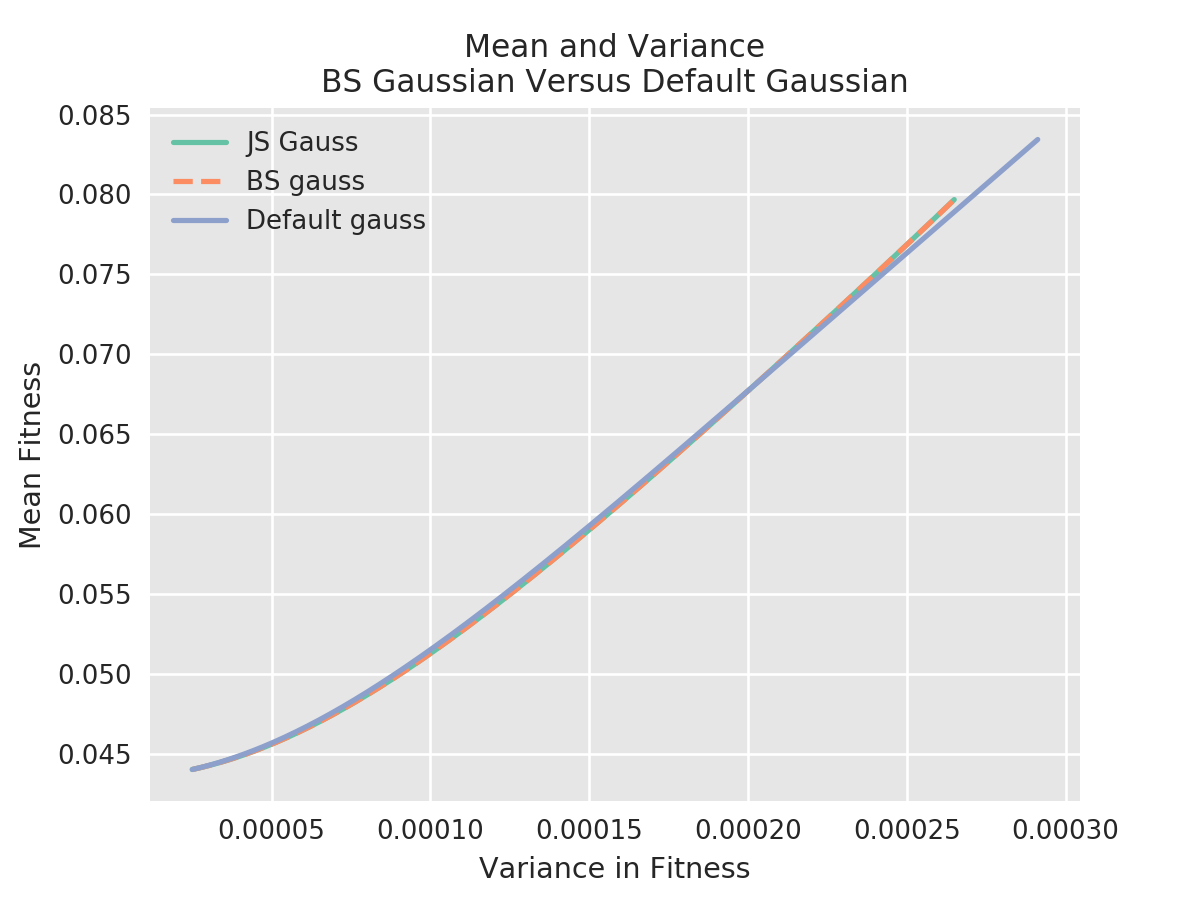

<IPython.core.display.Javascript object>


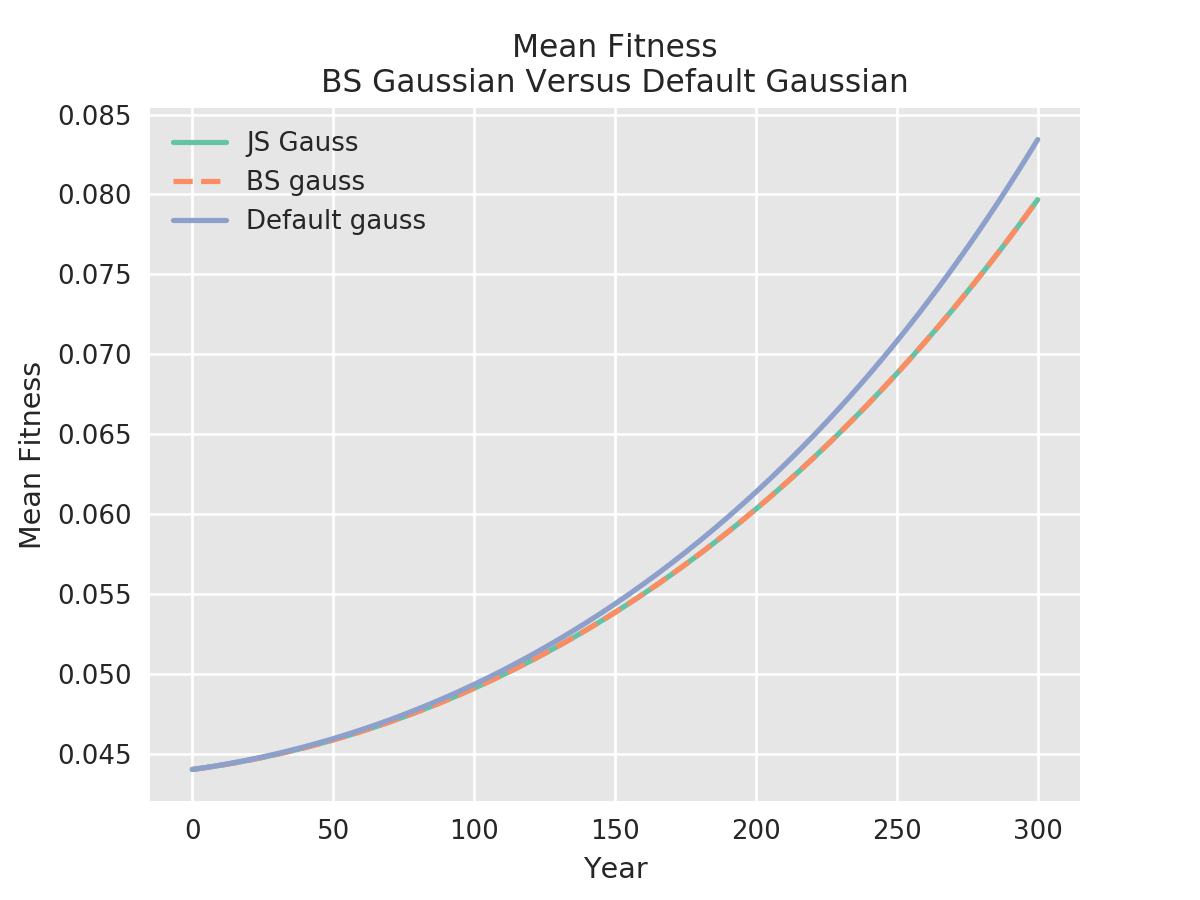

<IPython.core.display.Javascript object>


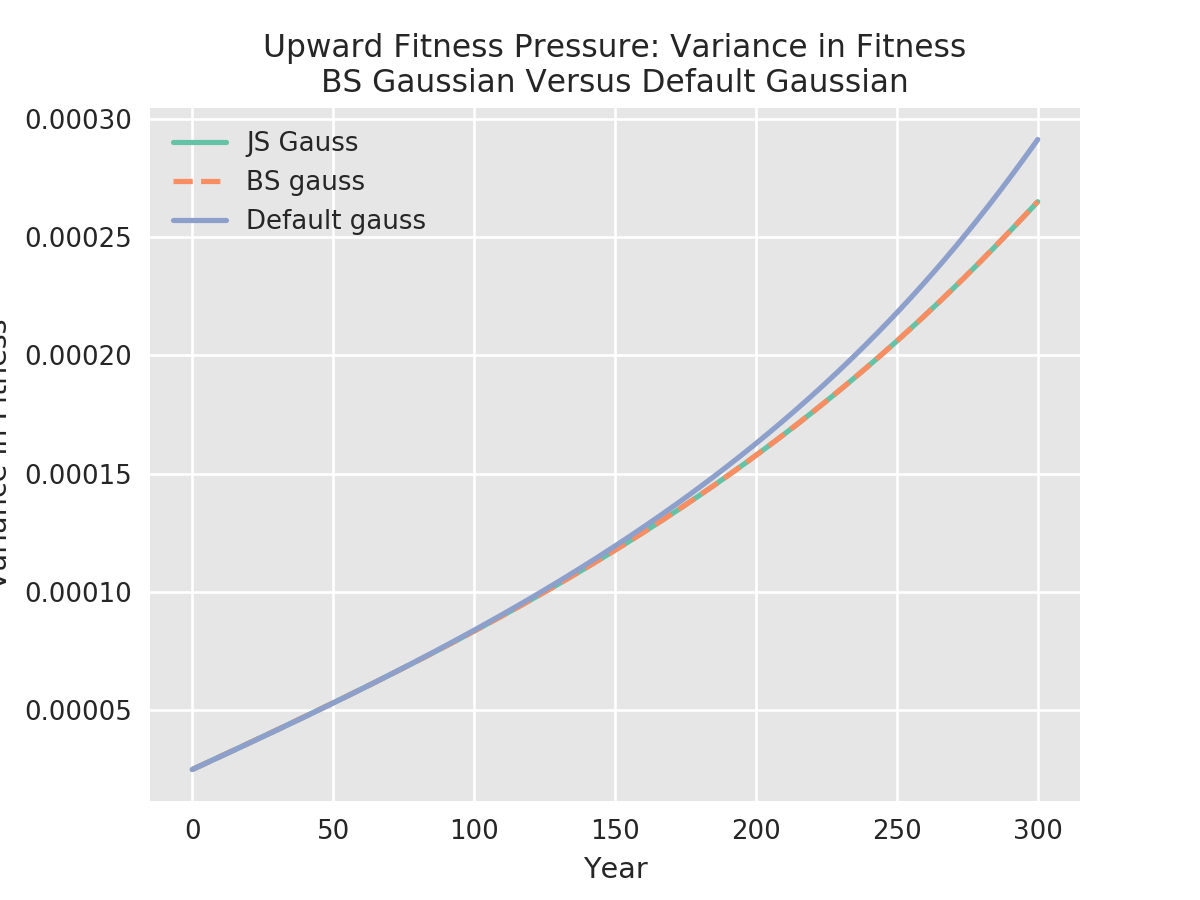

<IPython.core.display.Javascript object>


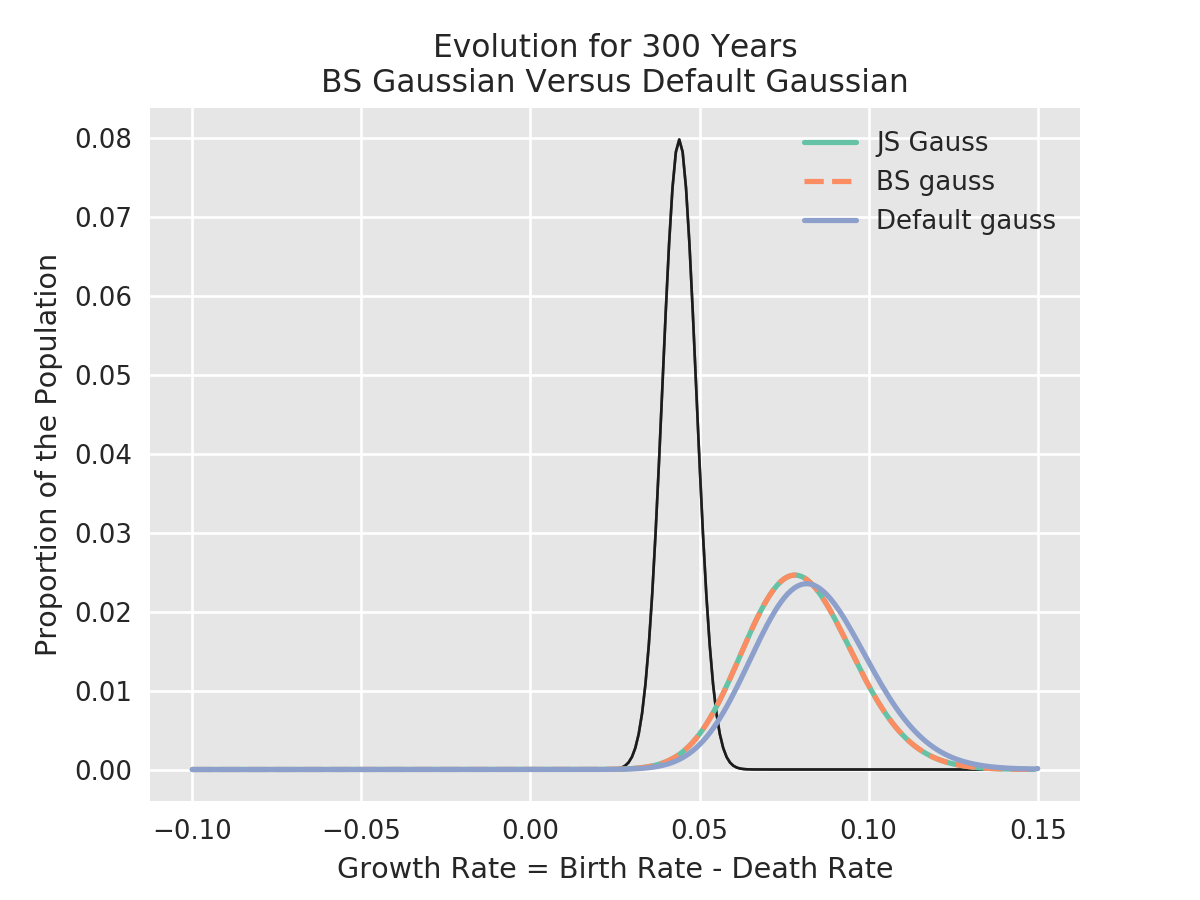

In [55]:
bs_gauss_compare = CompareProcesses([js_gauss, bs_gauss, gauss])
bs_gauss_compare.set_subtitle('\nBS Gaussian Versus Default Gaussian')
bs_gauss_compare.mean_variance_plots(line_styles=['-', '--', '-'])
bs_gauss_compare.animate(NFRAMES, line_styles=['-', '--', '-']) # Set nframes=100 for animation

The difference in the default Gaussian and the BS Gaussian processes is due primarily to the difference their in handling of rates. As the populations shift to the right, there is greater error in treating the birth rates as linear factors rather than as log-scale factors. I'll have more to say about this when we get to replication of the experiments reported upon in BS Sections 5.1 and 5.2.

## Reflected, weighted Gamma distribution over mutation effects

Run Basener's script for the Gamma case (Section 5.4) of the BS article. Convert the results to an instance of the `WrappedTrajectory` subclass of `Evolution`.

We proceed much as in the Gaussian case. The code will come in bigger chunks, and with less explanation.

In [56]:
n_rates = gamma_effects.n_rates
n_years = 2500
gamma = Evolution(gamma_pop, n_years=n_years)
bs_gauss = Evolution(bs_gamma_pop, n_years=n_years)

In [57]:
c = bs_command(percentage_of_mutations_that_are_beneficial=0.001,
                  mutation_distribution_type='Gamma',
                  population_size='Finite',
                  number_of_years=n_years+1,
                  number_of_discrete_population_fitness_values=n_rates-1,
                  script_path='BS.js',
                  output_path='BS.json')
!{c}
with open('BS.json') as json_data:
    bs_gamma_output = json.load(json_data)
    json_data.close()
js_gamma = WrappedTrajectory(bs_gamma_output['trajectory'], bs_gamma_output['growth_rates'], label='JavaScript')

[ '/usr/local/conda3/bin/node',
  '/home/chronos/user/Downloads/NewNotebooks/BS/BS.js',
  '0.001',
  'Gamma',
  'Finite',
  '2501',
  '500',
  'BS.json' ]
Working...
... done. Output is in BS.json


Here is a list of the dictionary keys associated with outputs from Basener's program.

<IPython.core.display.Javascript object>


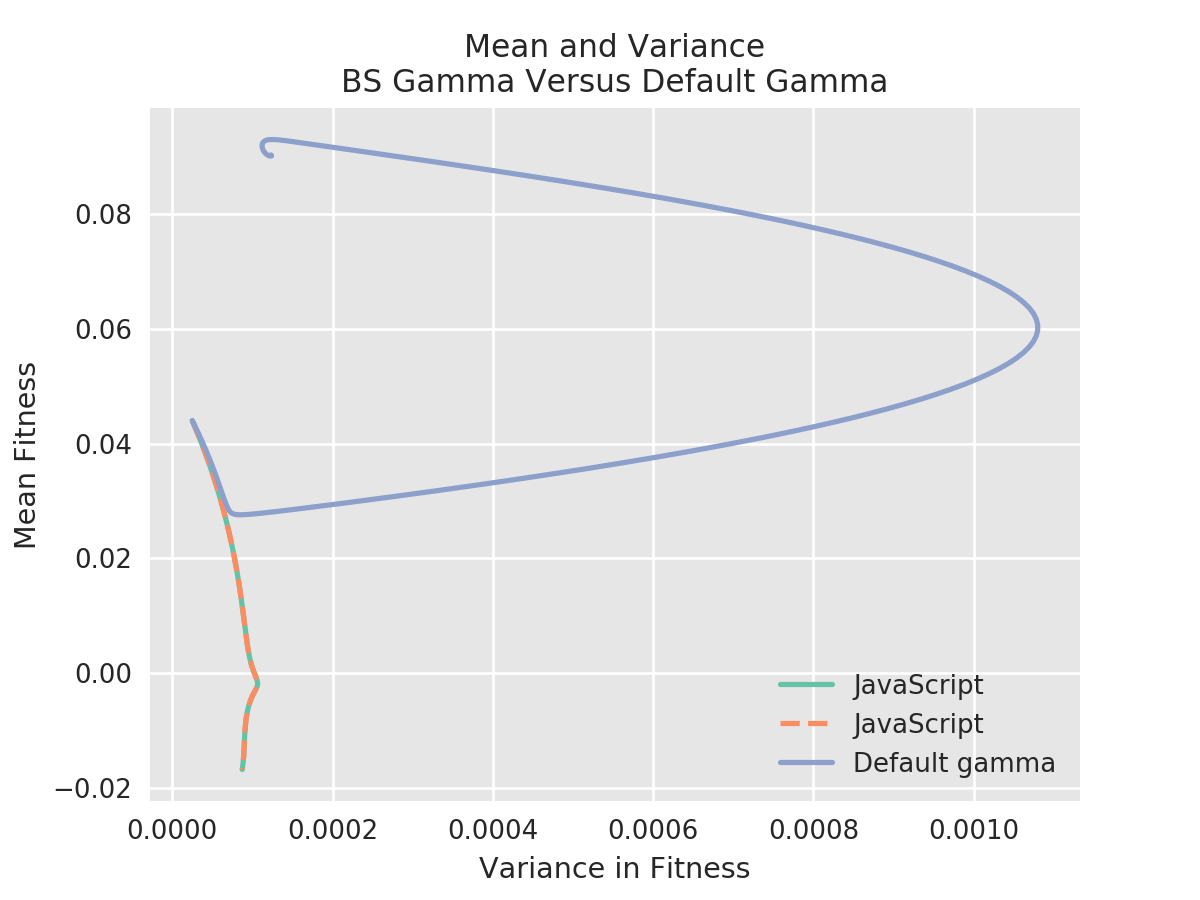

<IPython.core.display.Javascript object>


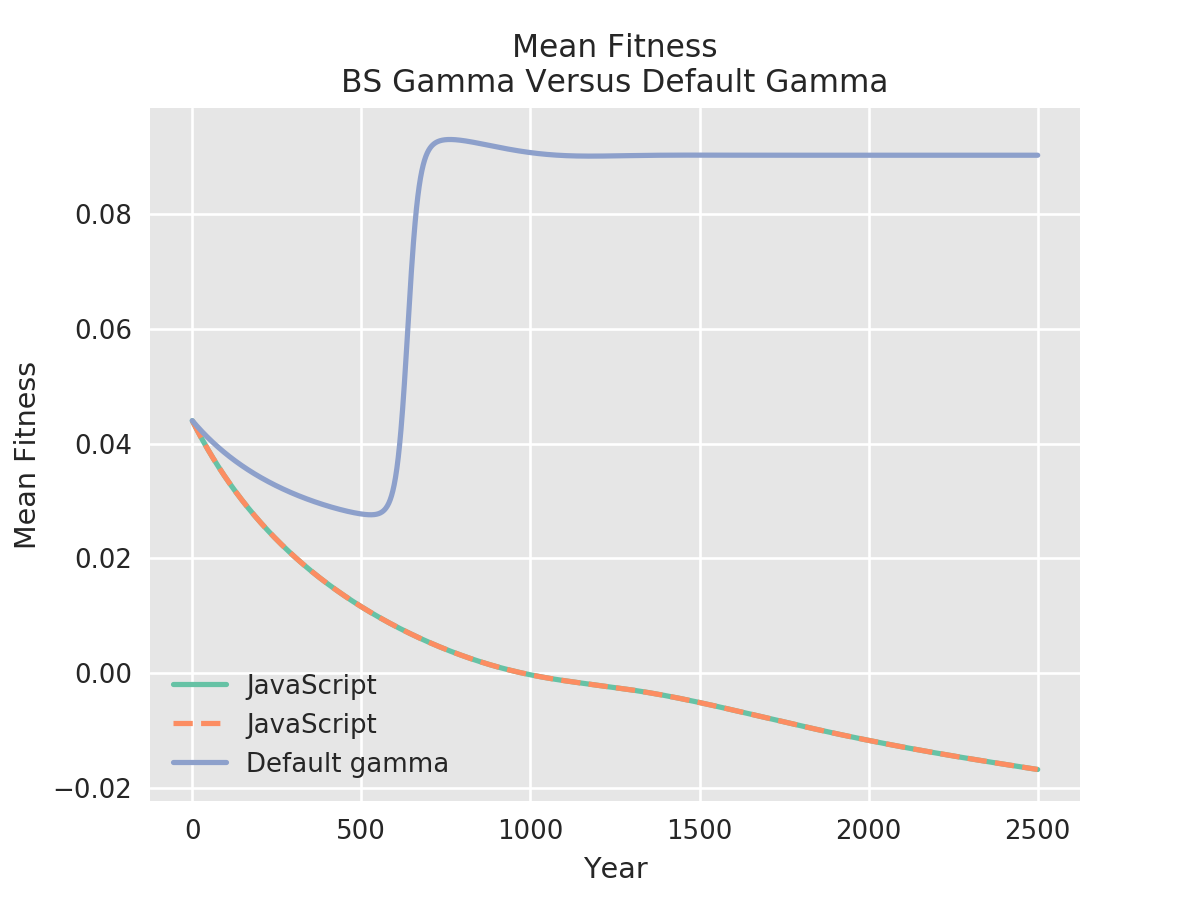

<IPython.core.display.Javascript object>


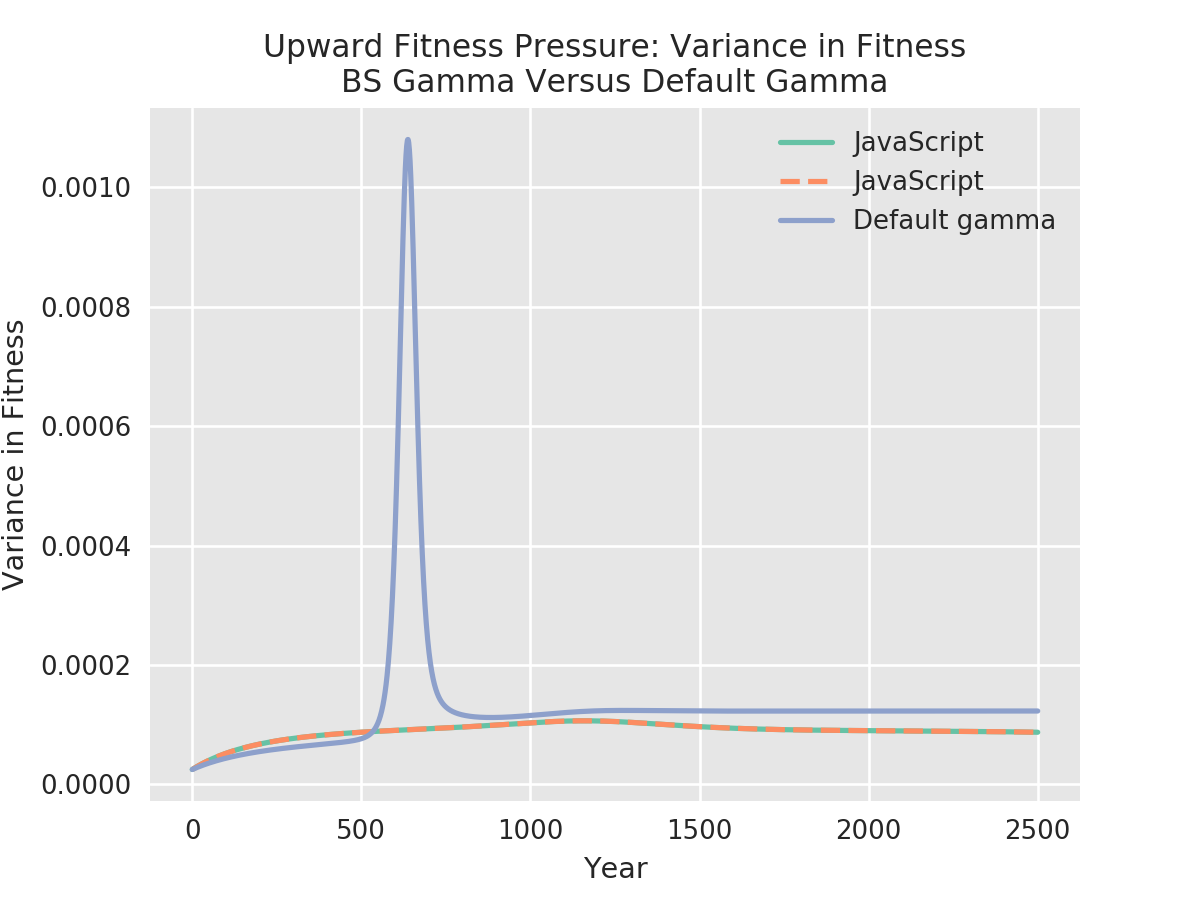

<IPython.core.display.Javascript object>


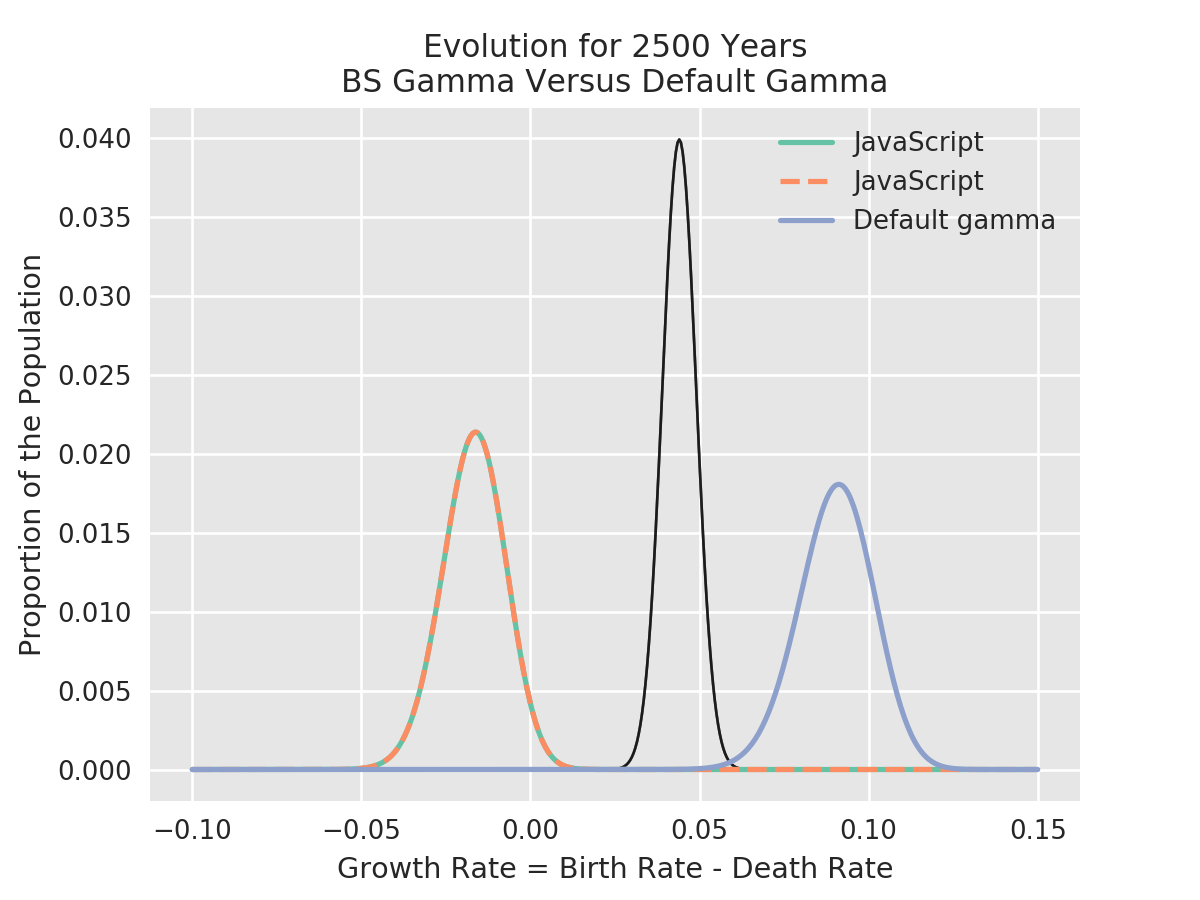

In [58]:
bs_gamma_compare = CompareProcesses([js_gamma, bs_gamma, gamma])
bs_gamma_compare.set_subtitle('\nBS Gamma Versus Default Gamma')
bs_gamma_compare.mean_variance_plots(line_styles=['-', '--', '-'])
bs_gamma_compare.animate(NFRAMES, line_styles=['-', '--', '-']) # Set nframes=100 for animation

**Basener's code for the Gamma case**

I'm going to simplify Basener's code. But I want you to see the starting point. You need only pay close attention to the first two lines. Note that `mDiff` is the difference in Malthusian growth rate of the offspring from the parent, and that `mDelta` is the minimum difference of two growth rates.

```javascript
if (mDiff == 0)      // If the difference in Malthusian growth rate is 0...
    mDiff = -mDelta; // then set it to the least negative difference.
var sBarBeneficial = 0.001;
var sBarDeleterious = 0.001;
var aBeneficial = 0.5;
var aDeleterious = 0.5;
var bBeneficial = aBeneficial / sBarBeneficial;
var bDeleterious = aDeleterious / sBarDeleterious;
if (mDiff > 0) 
    f = (PctBeneficial) * Math.pow(bBeneficial, aBeneficial)
                        * Math.pow(mDiff, aBeneficial - 1)
                        * Math.exp(-bBeneficial * mDiff)
                        / Gamma(aBeneficial);
if (mDiff < 0)
    f = (1 - PctBeneficial) * Math.pow(bDeleterious, aDeleterious)
                            * Math.pow(Math.abs(mDiff), aDeleterious - 1)
                            * Math.exp(-bDeleterious * Math.abs(mDiff))
                            / Gamma(aDeleterious);
f = f * mDelta;
```
The most charitable interpretation is that Basener had expected the interval of growth rates to be sliced so finely that the probability mass of the subinterval containing 0 would be very small. Then his weighting would give nearly the correct result. But the result is nowhere close to correct in the experiment that BS present.

# No mutations (Section 5.1 and 5.2)

Basener treats this as a special case. We do not have to when using class `Population`.

In [ ]:
n_rates = N_BINS['NoneExact']
n_years = 3500
c = bs_command(percentage_of_mutations_that_are_beneficial=0.001,
                  mutation_distribution_type='NoneExact',
                  population_size='Infinite',
                  number_of_years=n_years+1,
                  number_of_discrete_population_fitness_values=n_rates-1,
                  script_path='BS.js',
                  output_path='BS.json')
!{c}
with open('BS.json') as json_data:
    bs_none_output = json.load(json_data)
    json_data.close()
bs_none = WrappedTrajectory(bs_none_output['trajectory'], bs_none_output['growth_rates'], label='Equation')

In [ ]:
initial_dist = GaussianRates(n_rates, approximate=True, crop=11.2)
pop = Population(initial_dist, EffectsDistribution(n_rates), label='Iteration')
none_ev = Evolution(pop, n_years=n_years)
c = CompareProcesses([bs_none, none_ev], subtitle='\nNo mutations')
c.mean_variance_plots()

In [ ]:
c.animate(NFRAMES)

Compare the size of the population according to the formula to the size resulting from iterative update of the population without mutation.

In [ ]:
np.sum(bs_none[-1]), np.sum(none_ev[-1])

Next we use the formula to calculate what the size of the population is after `n_years` annual updates.

In [ ]:
np.sum(none_ev[0] * np.exp(n_years * none_ev.growth_rates()))

In [ ]:
bs_none[-1][464], none_ev[-1][464]

In [ ]:
bs_none_output['growth_rates'][464], none_ev.growth_rates()[464]